In [3]:
import os

'.'

In [2]:
import cv2
import torch
import json
import os

## Read JSON config file

In [4]:
DATA_TRAIN_FILE = '../training/data/data_train.json'

assert os.path.exists(DATA_TRAIN_FILE)

with open(DATA_TRAIN_FILE, 'r') as f:
    data_train = json.load(f)

AssertionError: 

Data_train is an JSON array. Each element of the array is an object with 3 keys:

- `id` - the image id. The image file is with same name and **.png** extention in `/data/images` folder
- `metric` - we won't need this
- `kps` - keypoints array of 14 elements. Each element of the array is an array with 2 elements - x, y coordinates of the key point

In [3]:
data_train[0]

{'id': 'PuXlxKdUIes_2450',
 'metric': 0.28256459215943674,
 'kps': [[378, 186],
  [905, 184],
  [242, 566],
  [1058, 564],
  [445, 185],
  [345, 566],
  [839, 185],
  [956, 564],
  [428, 247],
  [858, 246],
  [377, 445],
  [919, 443],
  [643, 247],
  [648, 444]]}

## Visualize random image from the data

Selected: 1718
File path: ./data/images/DeMOiVb3Ufw_1250.png
<class 'numpy.ndarray'>
(720, 1280, 3)


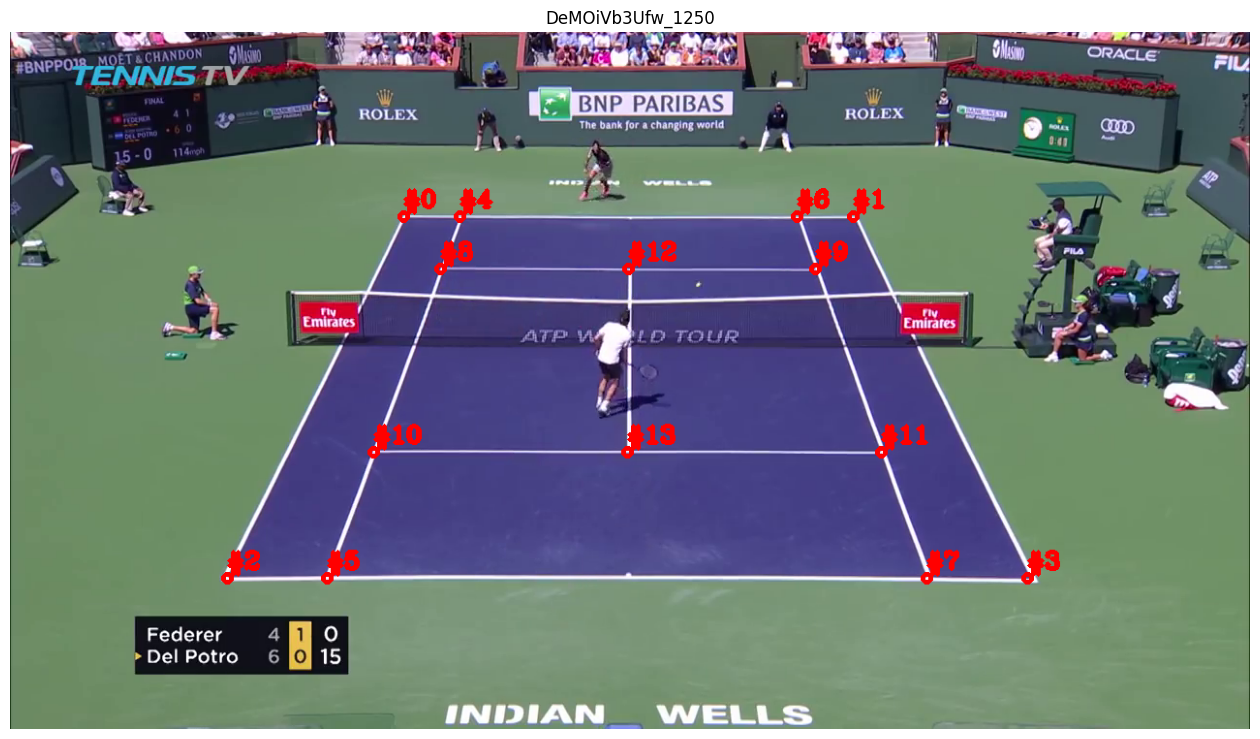

In [4]:
%matplotlib inline

import random
import matplotlib.pyplot as plt

IMAGES_FOLDER = './data/images/'
IMAGE_EXT = '.png'

size = len(data_train)
random_idx = random.randint(0, size)
print(f'Selected: {random_idx}')

def read_image(idx: int):
    record = data_train[idx]

    file_path = f'{IMAGES_FOLDER}{record["id"]}{IMAGE_EXT}'

    print(f'File path: {file_path}')

    assert os.path.exists(file_path)
    frame = cv2.imread(filename=file_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame, record['kps']

def draw_keypoints(frame, keypoints, color=(255, 0, 0), thickness=4):

    for i, (x, y) in enumerate(keypoints):
        frame = cv2.circle(frame, center=(int(x), int(y)), radius=4, color=color, thickness=thickness)
        frame = cv2.putText(frame, f'#{i}', (int(x), int(y) - 10), cv2.FONT_HERSHEY_COMPLEX, .8, color, thickness)
    return frame

frame, keypoints = read_image(idx=random_idx)
print(type(frame))
print(frame.shape)

frame = draw_keypoints(frame, keypoints)

plt.figure(figsize = (16, 16))
plt.imshow(frame)
plt.title(f'{data_train[random_idx]["id"]}')
plt.axis('off')
plt.show()

I do NOT like the order of the points, let's sort `kps` by the following formula: 0.9 * height + 0.1 width.
And then try again.


In [5]:
from tqdm import tqdm
import sys
import numpy as np

def order_points(kps, coef=.1):
    """Orders keypoints by its coordinates by coef * x[0] + (1-coef)*x[1].
    Push points with coordinates [0,0] at the end.

    Args:
        kps (list): keypoinst, can be [x,y] or [x, y, vis] 
        coef (float, optional): the importance of x[1] coordinate. Defaults to .1.

    Returns:
        list: Keypoints ordered by the described criteria.
    """
    res = sorted(kps, key = lambda x: 
                 (x[0] * coef) + ((1 - coef) * x[1])
                 if x[0] != 0 and x[1] != 0 else sys.maxsize)
    return res

def order_points_v2(kps: list[tuple|list], return_center=False, alpha=10):
    """
    Processes and sorts an array of arrays of 2 elements [x, y].

    This function performs the following steps:
    1. Takes an input array of arrays, each containing two elements [x, y].
    2. Sorts the input array by the second element (y) where x and y are not 0.
    3. While the new array is not empty:
        3.1. Calculates the minimum y coordinate from the remaining points.(Just get the first point y coordinate
            as they are already sorted)
        3.2. Pops the first element from the new array while the difference 
             between the element's y and the minimum y is less than or equal to alpha.
        3.3. Adds the popped elements to a new array (batch).
        3.4. Sorts the popped elements (batch) by the first element (x) and adds them to the result.
        3.4. Empty the batch
        3.5. Repeats the process (3.) until the new array is empty.
    4. Adds all element with x == y == 0 from the original array at the end of result array.
        
    Args:
        kps (list[tuple | list]): keypoints. Can be points of type [x, y] or [x, y, vis] where vis is visibility(0 or 1)
        return_center (bool, optional): if True the center point will be returned. Defaults to False.
        alpha (int): The possible difference between 2 points y coordinate to be in a batch. Defaults to 10.
    Returns:
        list: Keypoints sorted by the distance to the center.
    """
    non_zero_kps = [kp[:2] for kp in kps if kp[0] != 0 and kp[1] != 0]
    zero_kps = [kp[:2] for kp in kps if kp[0] == kp[1] == 0]
    # sort by y coordinate
    sorted_kps = sorted(non_zero_kps, key=lambda point: point[1])
    new_kps = []

    min_y = non_zero_kps[0][1]

    while len(sorted_kps) > 0:

        batch = []
        while len(sorted_kps) > 0 and sorted_kps[0][1] - min_y <= alpha:
            # Add first point to the batch
            batch.append(sorted_kps.pop(0))
        
        if len(batch) > 0:
            # Append points to the result sorted by x coordinate
            new_kps.extend(sorted(batch, key=lambda point: point[0]))
            batch = []

        if len(sorted_kps) > 0:
            min_y = sorted_kps[0][1]

    new_kps.extend(zero_kps)

    if return_center:
        center_point =  np.array(non_zero_kps).mean(axis=0).tolist()
        return new_kps, center_point
    return new_kps

Points before: [[505, 171], [1032, 169], [258, 555], [1285, 570], [570, 170], [382, 556], [965, 170], [1151, 568], [544, 223], [990, 223], [451, 415], [1082, 420], [765, 223], [762, 417]]
Points: [[505, 171], [570, 170], [965, 170], [1032, 169], [544, 223], [765, 223], [990, 223], [451, 415], [762, 417], [1082, 420], [258, 555], [382, 556], [1151, 568], [1285, 570]]
Center: [767.2857142857143, 346.42857142857144]
File path: ./data/images/7Zet_ieK_JM_800.png
<class 'numpy.ndarray'>
(720, 1280, 3)


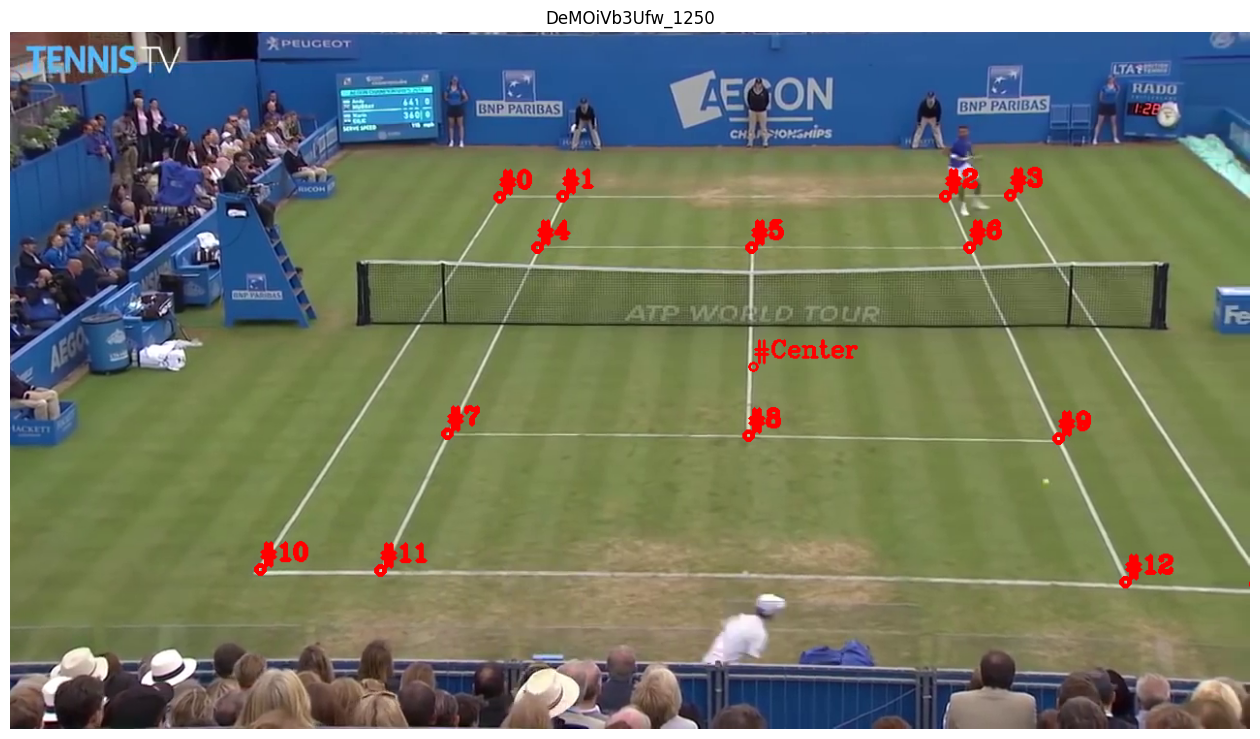

In [6]:
index = 51
record = data_train[index]
print(f'Points before: {record["kps"]}')
points, center = order_points_v2(record['kps'], return_center=True)

print(f'Points: {points}')
print(f'Center: {center}')

frame, _ = read_image(idx=index)
print(type(frame))
print(frame.shape)

frame = draw_keypoints(frame, points)

frame = cv2.circle(frame, center=(int(center[0]), int(center[1])), radius=4, color=(255, 0, 0), thickness=2)
frame = cv2.putText(frame, '#Center', (int(center[0]), int(center[1]) - 10), cv2.FONT_HERSHEY_COMPLEX, .8, (255, 0, 0), 2)

plt.figure(figsize = (16, 16))
plt.imshow(frame)
plt.title(f'{data_train[random_idx]["id"]}')
plt.axis('off')
plt.show()

In [7]:
for idx in tqdm(range(len(data_train))):
    record = data_train[idx]
    new_points = order_points_v2(record['kps'])
    data_train[idx]['kps'] = new_points

100%|██████████| 6630/6630 [00:00<00:00, 172127.53it/s]


## Resize image to 480x480

Selected: 3157
File path: ./data/images/UwuccciC0Jg_150.png
New image shape: (480, 480, 3)


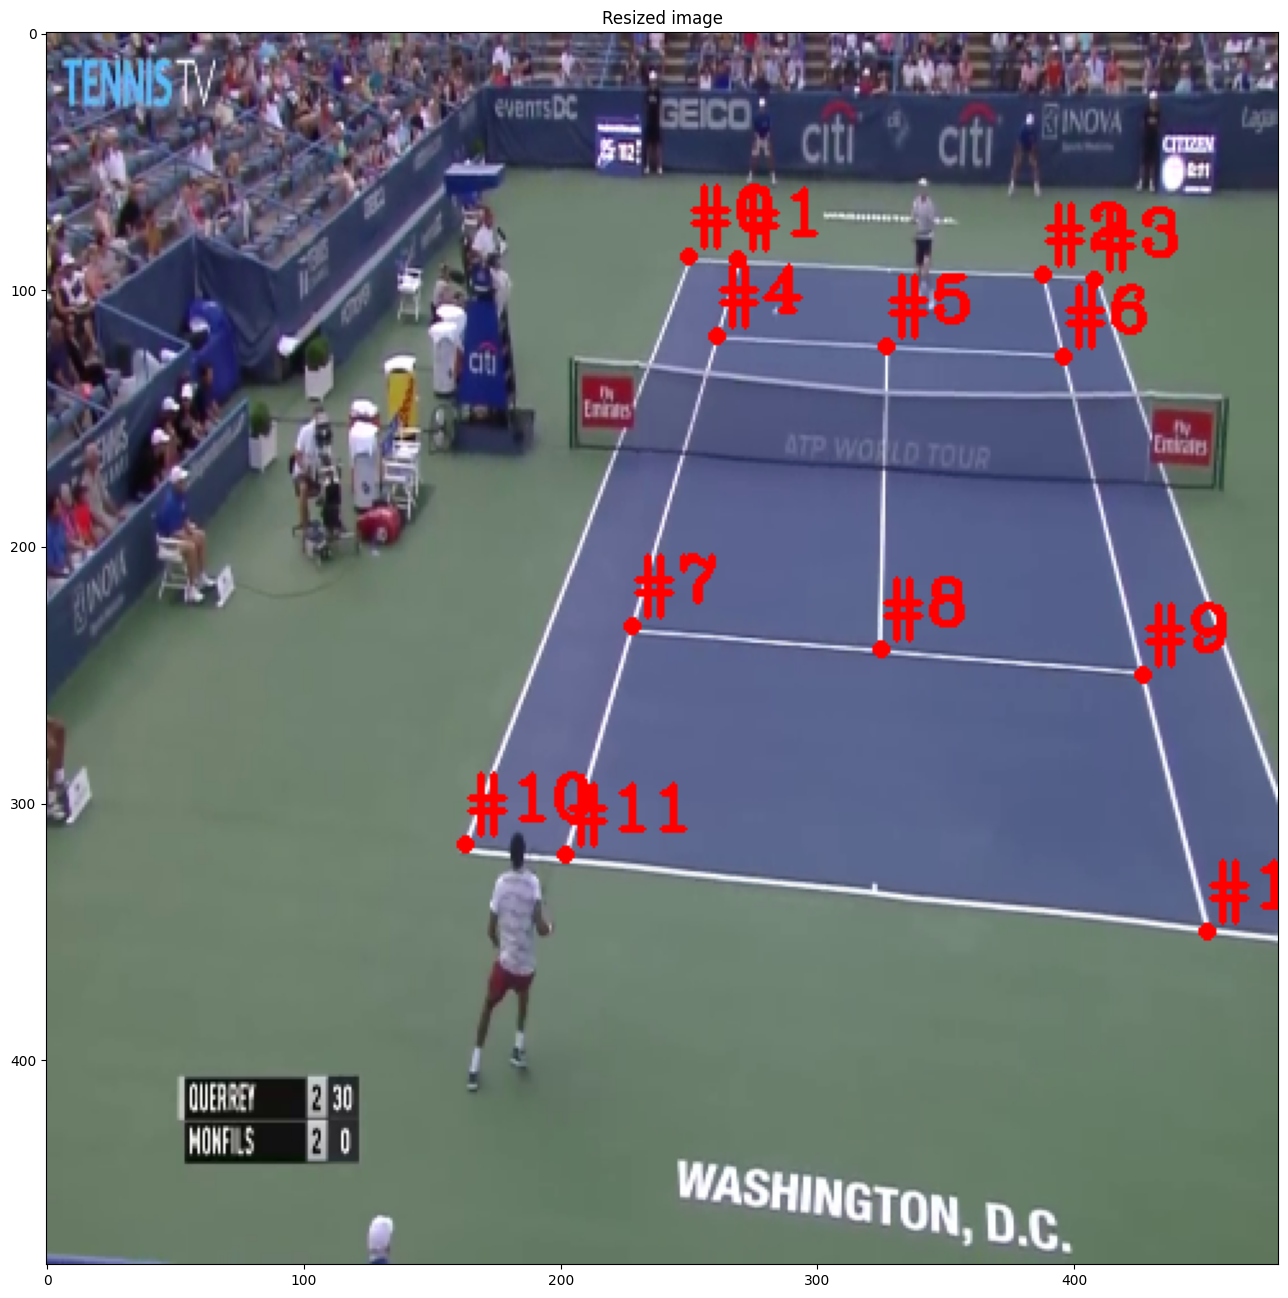

In [8]:
img_size = 480

# Select random image
random_idx = random.randint(0, size)
print(f'Selected: {random_idx}')

img_data, keypoints = read_image(random_idx)

h, w = img_data.shape[:2]

resized_keypoints = [[int(x / w * img_size), int(y / h * img_size)] for x, y in keypoints]
resized_image = cv2.resize(img_data, (img_size, img_size))

print(f'New image shape: {resized_image.shape}')

for i, (x, y) in enumerate(resized_keypoints):
    resized_image = cv2.circle(resized_image, center=(x, y), radius=2, color=(255, 0, 0), thickness=2)
    resized_image = cv2.putText(resized_image, f'#{i}', (int(x), int(y) - 10), cv2.FONT_HERSHEY_COMPLEX, .8, (255, 0, 0), 2)

plt.figure(figsize = (16, 16))
plt.imshow(resized_image)
plt.title('Resized image')
plt.show()

## Just for test purpose: UnNormalize

As we will normalize our images. If we want to visualize them for test purposes, we create `UnNormalize` class to return the image into the proper format for visualization.

In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


Selected image index: 221
File path: ./data/images/bcvYuzo_lt8_2500.png
Data keys: dict_keys(['image', 'keypoints'])
Img_data shape: (400, 400, 3), img_data type: <class 'numpy.ndarray'>
Keypoints after: [(61.50906228820364, 151.3987313048349), (90.28915232732763, 144.37398630306325), (262.44730616209904, 101.66678389354445), (291.22739620122303, 94.6420388917728), (92.64602281211918, 185.65924928267495), (186.2723916735732, 162.8065978212153), (280.2630654722313, 139.8650255369484), (101.20116487084357, 318.76002497087103), (219.23596452497236, 289.9496783813266), (337.63506911630526, 261.05041096897486), (372.6342618854961, 334.8562813689981)]


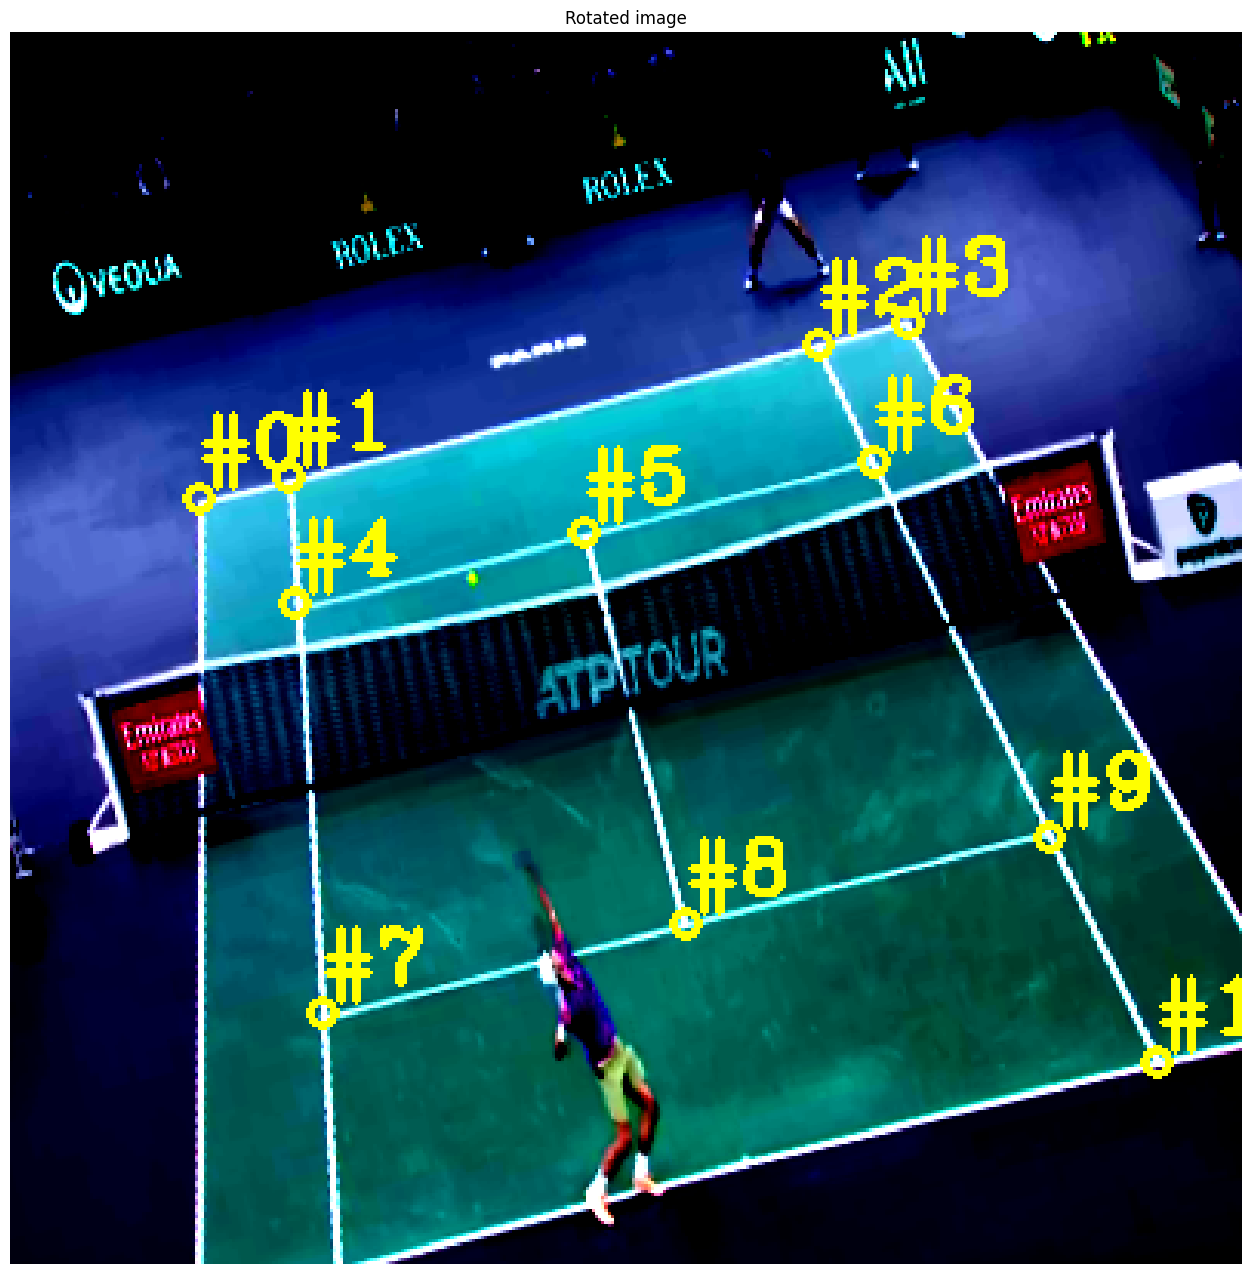

In [10]:
%matplotlib inline

import torchvision.transforms as T
import random
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

my_transforms = A.Compose([
    A.Resize(480, 480),
    A.Normalize(mean=(.485, .456, .406), std=(.229, .224, .225)),
    A.Rotate(15),
    A.RandomCrop(400, 400),
    # ToTensorV2(always_apply=True)
], keypoint_params=A.KeypointParams(format='xy'))

image_index = random.randint(0, len(data_train) - 1)
print(f'Selected image index: {image_index}')

img_data, keypoints = read_image(idx=image_index)

img_data = my_transforms(image=img_data, keypoints=keypoints)
print(f'Data keys: {img_data.keys()}')

img_data, keypoints = img_data['image'], img_data['keypoints']
print(f'Img_data shape: {img_data.shape}, img_data type: {type(img_data)}')
print(f'Keypoints after: {keypoints}')

# Let's show the image
# img_data = unnorm(img_data).numpy()

frame = draw_keypoints(img_data, keypoints, color=(255, 255, 0), thickness=2)

plt.figure(figsize = (16, 16))
plt.imshow(frame)
plt.title('Rotated image')
plt.axis('off')
plt.show()

## Create dataset

In [11]:
import cv2

def read_data_image(image_dir: str, data: list, idx: int):
    """Reads an image from image_dir by given data and given index
    and return its content as numpy.ndarray and keypoints.
    Keypoints are sorted based on order_points_v2 method.

    Args:
        image_dir (str): the directory where images are located
        data (list): data records array
        idx (int): index of wanted image

    Returns:
        tuple: tuple of image_data (numpy.ndarray) and keypoints (list with shape (14, 2))
    """
    record = data[idx]
    file_path = f'{image_dir}{record["id"]}{IMAGE_EXT}'
    assert os.path.exists(file_path)
    frame = cv2.imread(filename=file_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    kps = order_points_v2(record['kps'])

    return frame, kps

In [12]:
from typing import Any, Callable
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


class TennisKeypointsTransforms(Callable):
    def __init__(self, 
                 img_size: int|tuple[int],
                 rotate: int,
                 normalize:bool=True,
                 keypoints_format='xy'):
        if isinstance(img_size, int):
            self.img_size = (img_size, img_size)
        else:
            self.img_size = img_size

        transformations = []
        if (rotate > 0):
            transformations.append(A.Rotate(rotate))

        transformations.append(A.Resize(self.img_size[0], self.img_size[1]))
        if normalize:
            transformations.append(
                A.Normalize(mean=(.485, .456, .406), std=(.229, .224, .225)))

        transformations.append(ToTensorV2(always_apply=True))

        self.transform = A.Compose(
            transformations,
            keypoint_params=A.KeypointParams(format=keypoints_format, remove_invisible=False))

    def __call__(self, image: np.ndarray, keypoints: list) -> dict[str, Any]:
        # image will be MatLike of shape [W, H, C]
        w, h = image.shape[:2]

        # Add visibility parameter to points
        keypoints_filtered = [self.create_new_keypoint(kp, self.is_point_visible(kp, (w, h)))\
                              for kp in keypoints]

        assert len(keypoints) == len(keypoints_filtered)

        # Get points for transformation
        kps = keypoints if len(keypoints[0]) == 2 else [kp[:2] for kp in keypoints_filtered]

        # Transforms
        data = self.transform(image=image, keypoints=kps)
        trn_image, trn_kps = data['image'], data['keypoints']

        assert len(keypoints) == len(trn_kps)

        ## Add previous visiblity calculated
        trn_kps = [[kp[0], kp[1], keypoints_filtered[idx][2]] for idx, kp in enumerate(trn_kps)]

        # Every element of trn_kps is an array of 2 elements [x, y] 
        # Let's add visibility to the point

        trn_kps = [self.create_new_keypoint(kp, self.is_point_visible(kp, self.img_size)) for kp in trn_kps]
        
        # Push not visible at the end
        trn_kps = sorted(trn_kps, key=lambda x: x[2], reverse=True)

        return {
            'image': trn_image,
            'keypoints': trn_kps
        }            

    def is_point_visible(self, point: tuple[int|float]|list[int|float], img_size: tuple[int]=None) -> bool:
        """Check if point is visible or not. If len of point is 3 and it is already invisible,
        we won't check and will return False.
        Point is visible if x, y coordinages are in range [0, width/height]

        Args:
            point (tuple[int | float]): point with x, y coordinates
            img_size (tuple[int], optional): Tuple of (width, height). Defaults to None. If None, self.img_size will be get

        Returns:
            bool: x >= 0 and x < width and y >= 0 and y < height
        """
        if len(point) == 3 and point[2] == 0:
            return False

        x, y = point[0], point[1]
        h, w = img_size if img_size else self.img_size

        return x >= 0 and x < w and y >= 0 and y < h

    def create_new_keypoint(self,
                            point: tuple[int|float]|list[int|float],
                            visible: bool) -> list[int|float]:
        """Function that accepts point and visibility state.
        Return a list with 3 values [x, y, vis], where x, y are point coordinates
        if the point is visible, 0, 0 otherwise and vis = 1 if point is visible,
        0 otherwise.

        Args:
            point (tuple[int | float]): key point
            visible (bool): if point is visible or not

        Returns:
            list[int|float]: list with format [x, y, vis]
        """
        assert len(point) in [2, 3]
        if visible:
            return [point[0], point[1], 1]
        return [0, 0, 0]

Keypoints before: [[505, 171], [570, 170], [965, 170], [1032, 169], [544, 223], [765, 223], [990, 223], [451, 415], [762, 417], [1082, 420], [258, 555], [382, 556], [1151, 568], [1285, 570]]
Image shape: torch.Size([3, 480, 480])
New keypoints: [[165.75, 158.66666666666666, 1], [188.25, 141.33333333333331, 1], [324.75, 38.666666666666664, 1], [347.625, 20.666666666666664, 1], [186.75, 180.66666666666666, 1], [263.25, 123.33333333333333, 1], [340.875, 64.66666666666666, 1], [182.625, 322.66666666666663, 1], [290.625, 243.33333333333331, 1], [401.625, 162.0, 1], [136.5, 458.66666666666663, 1], [179.625, 427.3333333333333, 1], [447.0, 234.66666666666666, 1], [0, 0, 0]]


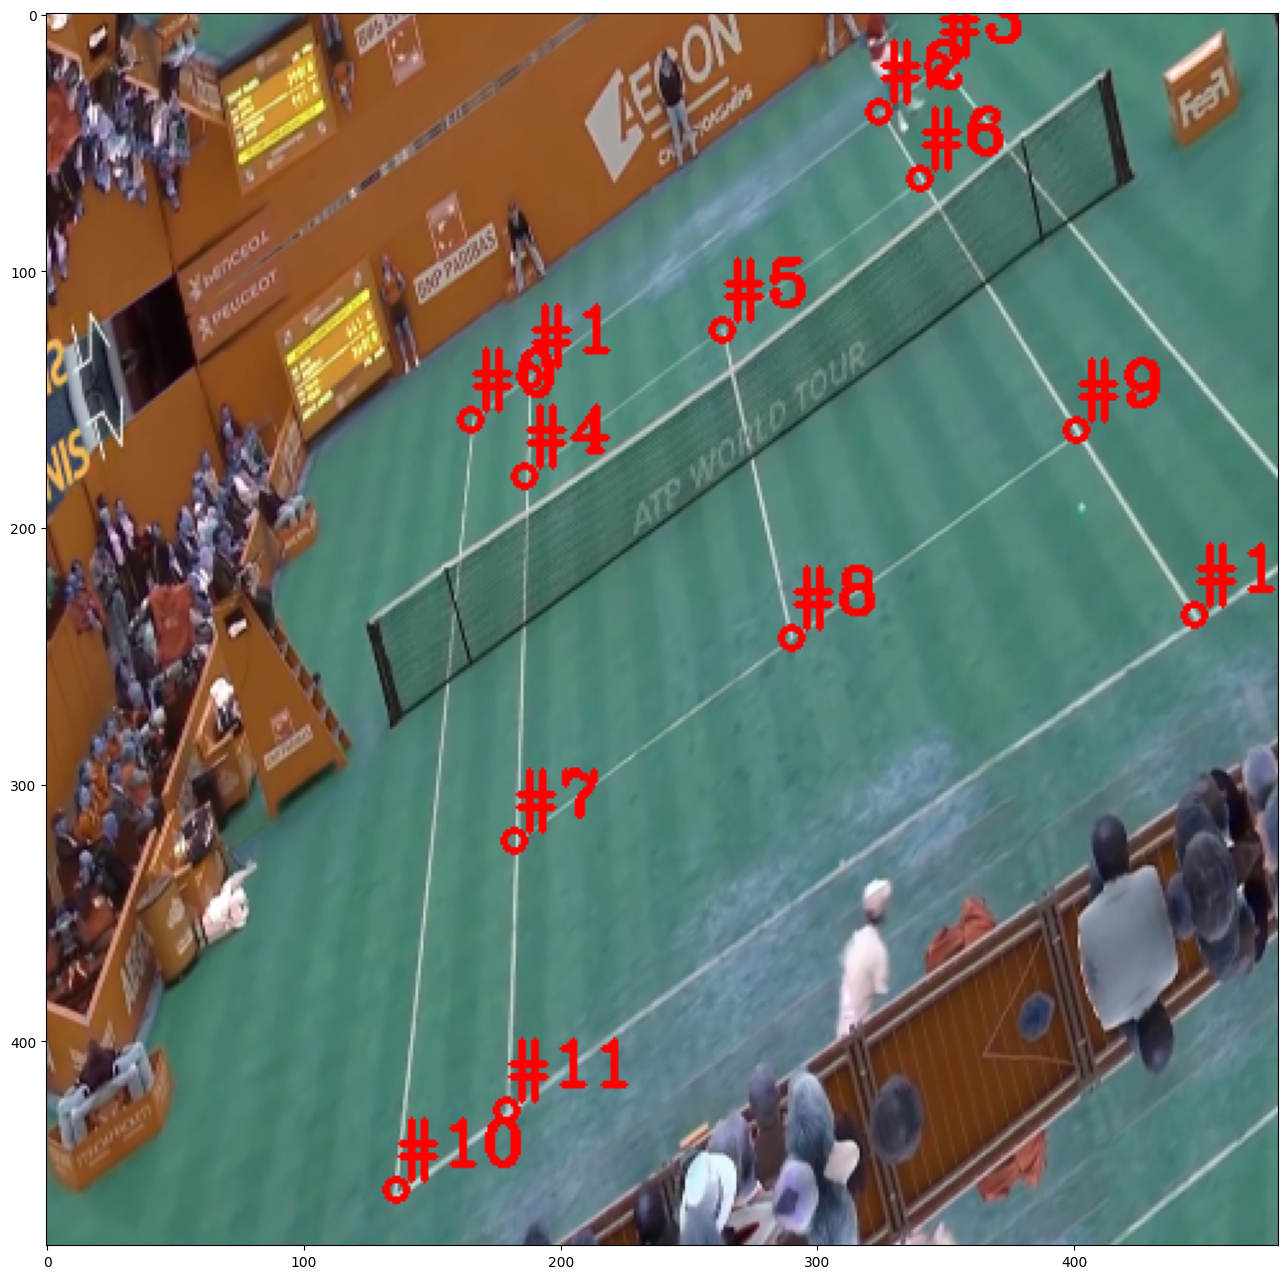

In [14]:
import cv2
import os
import torchvision.transforms.functional as F
import numpy as np

record = data_train[51]

image_path = f'{IMAGES_FOLDER}{record["id"]}{IMAGE_EXT}'

assert os.path.exists(image_path)

img_data = cv2.imread(image_path)
kps = record['kps']

print(f'Keypoints before: {kps}')

test_transform = TennisKeypointsTransforms(img_size=480, rotate=35,
                                           normalize=True, keypoints_format='xy')

result = test_transform(img_data, kps)

assert 'image' in result and 'keypoints' in result

trn_img, trn_kps = result['image'], result['keypoints']

print(f'Image shape: {trn_img.shape}')
print(f'New keypoints: {trn_kps}')

def draw_tensor(img_data: torch.Tensor, keypoints: torch.Tensor, conf_threshold=.5,
                unnormalize = True,
                **kwargs):
    kps = keypoints[keypoints[:, 2] > conf_threshold]

    if unnormalize:
        img_data = unnorm(img_data) # (3, 480, 480)
    
    img = img_data.permute(1, 2, 0).numpy() # (480, 480, 3)
    img = img * 255 

    img = np.ascontiguousarray(img, dtype=np.uint8)

    keypoints_t = [[(int(x)), int(y)] for x, y, _ in kps]
    img = draw_keypoints(img, keypoints_t, thickness=2, **kwargs)

    return img

frame = draw_tensor(trn_img, torch.tensor(trn_kps))

plt.figure(figsize = (16, 16))
plt.imshow(frame)
# plt.axis('off')
plt.show()


In [27]:
from torch.utils.data import Dataset, DataLoader
import os
import json

class KeypointsDataset(Dataset):
    def __init__(self, json_data: str, 
                 image_folder: str, 
                 transfrormations: TennisKeypointsTransforms,
                 num_keypoints=14) -> None:
        super().__init__()

        assert os.path.exists(json_data)
        assert os.path.exists(image_folder)

        with open(json_data) as f:
            self.data = json.load(f)

        self.image_folder = image_folder
        self.transformations = transfrormations
        self.num_keypoints = num_keypoints

    def __getitem__(self, index):
        img_data, kps = read_data_image(self.image_folder, self.data, index)

        # CV read return image in format [h, w, c]    
        h, w = img_data.shape[:2]

        if self.transformations:
            data = self.transformations(image=img_data, keypoints=kps)
            img_data, kps = data['image'], data['keypoints']
            
            # ToTensor converts shape to [c, h, w]
            h, w = img_data.shape[1:]

        # each key point is in format (x, y). We will divide them by h and w to make them between 0 and 1
        kps = [[x / h, y / w, vis] for x, y, vis in kps]
        
        # Some examples do NOT have exact number of keypoints
        if len(kps) != self.num_keypoints:
            while len(kps) != self.num_keypoints:
                if len(kps) > self.num_keypoints:
                    kps.pop()
                else:
                    kps.append([0, 0, 0])
        
        for k in kps:
            assert k[0] >= 0 and k[0] <= 1 and k[1] >= 0 and k[1] <= 1 and k[2] in [0, 1]

        return img_data, torch.tensor(kps, dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.data)

In [28]:
IMAGES_FOLDER = './data/images/'
DATA_TRAIN_FILE = './data/data_train.json'
DATA_VAL_FILE = './data/data_val.json'

train_transformations = TennisKeypointsTransforms(img_size=480, rotate=35,
                                                  normalize=True, keypoints_format='xy')

train_ds = KeypointsDataset(DATA_TRAIN_FILE, IMAGES_FOLDER, train_transformations)

val_transformations = TennisKeypointsTransforms(img_size=480, rotate=0,
                                                normalize=True, keypoints_format='xy')

val_ds = KeypointsDataset(DATA_VAL_FILE, IMAGES_FOLDER, val_transformations)

print(f'Train samples: {len(train_ds)}')
print(f'Validation samples: {len(val_ds)}')

Train samples: 6630
Validation samples: 2211


In [18]:
img, labels = train_ds[2394]
print(f'Image shape: {img.shape}')
print(f'Labels shape: {labels.shape}')

Keypoits count does NOT match. Wanted 14, but 13
Image shape: torch.Size([3, 480, 480])
Labels shape: torch.Size([14, 3])


In [26]:
def validate_dataset(ds: KeypointsDataset,
                     split: str = None, # Train, Validation or Test
                     expected_img_shape: torch.Size = torch.Size([3, 480, 480]),
                     expected_labels_shape: torch.Size = torch.Size([14, 3])):
    valid = True
    for idx in tqdm(range(len(ds)), desc=f'Validating dataset {split}'):
        record = ds[idx]
        img, labels = record

        if img.dtype != torch.float32:
            print(f'Image dtype does NOT match at index {idx}. Wanted torch.float32,\
                  but was {img.dtype}')
            valid = False

        if img.dtype != torch.float32:
            print(f'Labels dtype does NOT match at index {idx}. Wanted torch.float32,\
                  but was {labels.dtype}')
            valid = False

        if img.shape != expected_img_shape:
            print(f'Image shape does NOT match at index {idx}.\
                   Wanted {expected_img_shape}, but was {img.shape}')
            valid = False

        if labels.shape != expected_labels_shape:
            print(f'Labels shape does NOT match at index {idx}.\
                  Wanted {expected_labels_shape}, but was {labels.shape}')
            valid = False

    return valid

valid = validate_dataset(train_ds, 'Train')
print(f'Train dataset valid: {valid}')
valid = validate_dataset(val_ds, 'Validation')
print(f'Validation dataset valid: {valid}')

Validating dataset Train:  36%|███▋      | 2405/6630 [00:34<00:57, 73.35it/s]

Keypoits count does NOT match. Wanted 14, but 13


Validating dataset Train:  72%|███████▏  | 4755/6630 [01:07<00:26, 72.05it/s]

Keypoits count does NOT match. Wanted 14, but 13


Validating dataset Train:  72%|███████▏  | 4763/6630 [01:07<00:26, 71.18it/s]

Keypoits count does NOT match. Wanted 14, but 13


Validating dataset Train:  81%|████████  | 5360/6630 [01:16<00:18, 68.87it/s]

Keypoits count does NOT match. Wanted 14, but 13


Validating dataset Train: 100%|██████████| 6630/6630 [01:34<00:00, 70.45it/s]


Train dataset valid: True


Validating dataset Validation:  38%|███▊      | 835/2211 [00:10<00:17, 79.26it/s]

Keypoits count does NOT match. Wanted 14, but 13


Validating dataset Validation: 100%|██████████| 2211/2211 [00:28<00:00, 77.94it/s]

Validation dataset valid: True


## Visualize single image

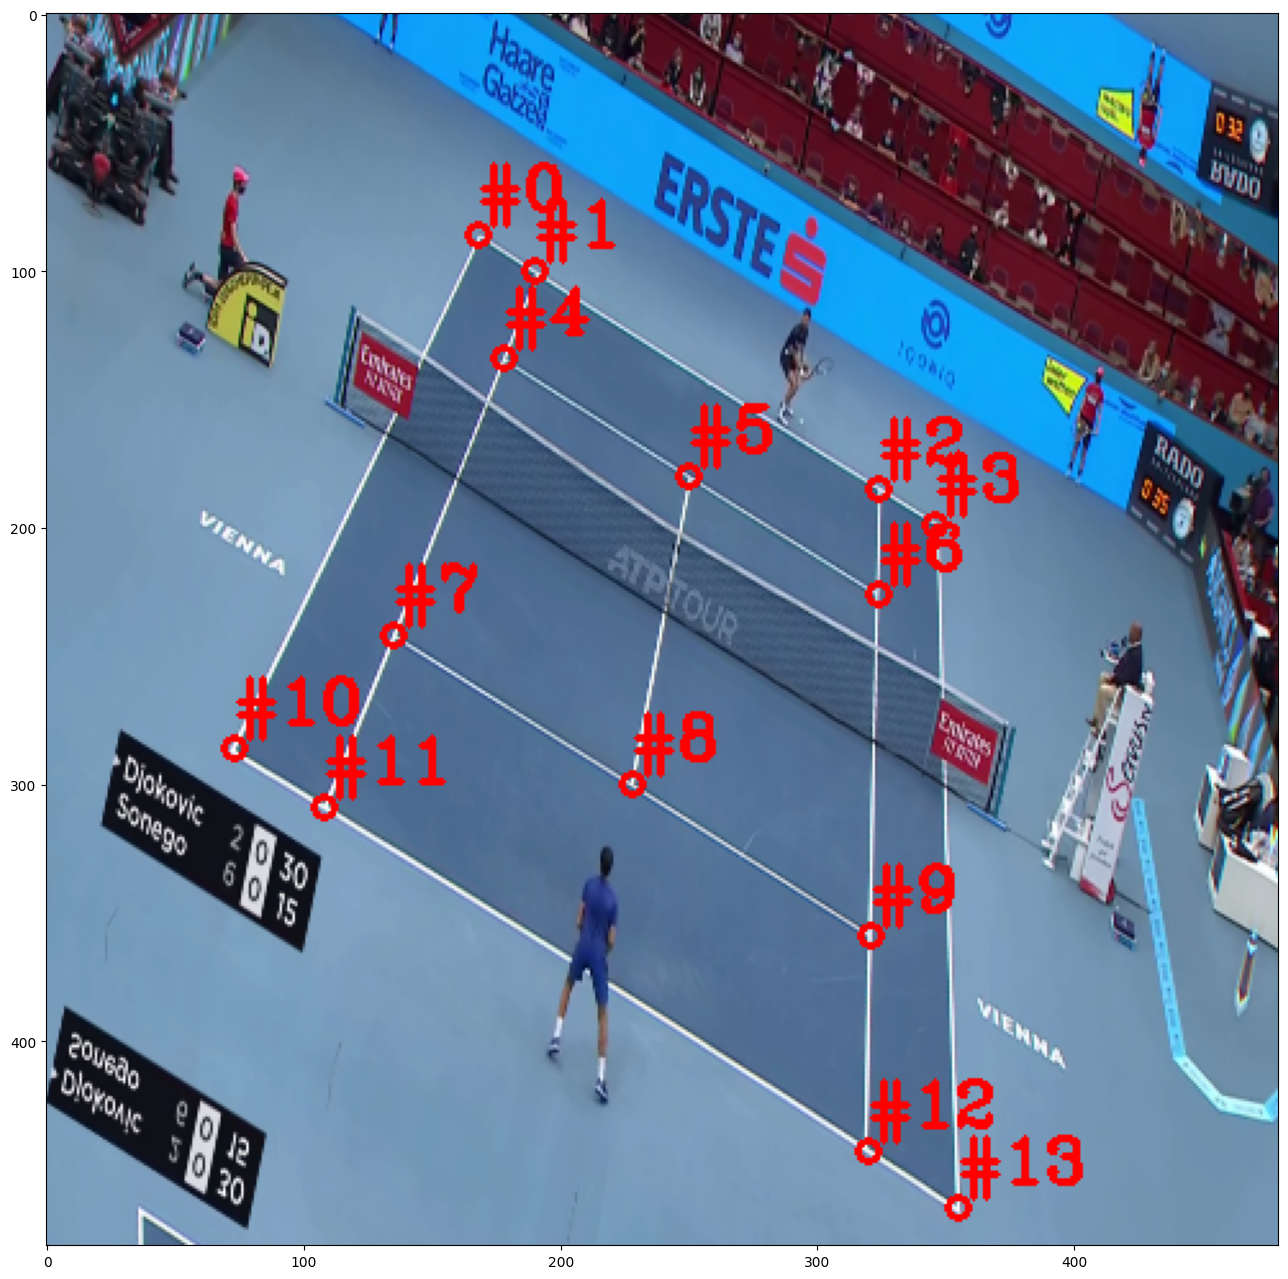

In [29]:
import torchvision.transforms.functional as F
import numpy as np

def draw_dataset_image(ds: KeypointsDataset, index: int):
    img_data, keypoints = ds[index] # (3, 480, 480)
    h, w = img_data.shape[1:] # h = w = 480

    img_data = unnorm(img_data) # (3, 480, 480)
    
    img = img_data.permute(1, 2, 0).numpy() # (480, 480, 3)
    img = img * 255 

    img = np.ascontiguousarray(img, dtype=np.uint8)

    keypoints = [[(int(x * h)), int(y * w)] for x, y, v in keypoints if v == 1]
    img = draw_keypoints(img, keypoints, thickness=2)

    return img

frame = draw_dataset_image(train_ds, 100)

plt.figure(figsize = (16, 16))
plt.imshow(frame)
# plt.axis('off')
plt.show()

## Define Data loader

In [30]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)

### Validate dataloaders

In [ ]:
for _ in tqdm(train_dl):
    pass

for _ in tqdm(val_dl):
    pass

In [25]:
size = torch.Size([3, 480, 480])
size.__getitem__()

3

In [ ]:
for idx, (x, y) in enumerate(train_dl):
    if x.dtype != torch.float32:
        print(f'Different dtype of x at batch {idx}. Wanted torch.float32, but was {x.dtype}')

    if y.dtype != torch.float32:
        print(f'Different dtype of y at batch {idx}. Wanted torch.float64, but was {y.dtype}')

In [31]:
min_x, min_y = 1000, 1000
max_x, max_y = -1000, -1000

shape_x = torch.Size([8, 3, 480, 480])
shape_y = torch.Size([8, 14, 3])

for x, y in tqdm(train_dl):
    if x.shape != shape_x:
        print(f'Diffrent shape X, wanted {shape_x}, but was {x.shape}')
    if y.shape != shape_y:
        print(f'Diffrent shape Y, wanted {shape_y}, but was {y.shape}')

    if torch.max(x).item() > max_x:
        max_x = torch.max(x).item()

    if torch.min(x).item() < min_x:
        min_x = torch.min(x).item()

    if torch.max(y).item() > max_y:
        max_y = torch.max(y).item()

    if torch.min(y).item() < min_y:
        min_y = torch.min(y).item()

print(f'Min of x: {min_x}, Max of x {max_x}')
print(f'Min of y: {min_y}, Max of y {max_y}')
    

100%|██████████| 829/829 [01:06<00:00, 12.39it/s]

Diffrent shape X, wanted torch.Size([8, 3, 480, 480]), but was torch.Size([6, 3, 480, 480])
Diffrent shape Y, wanted torch.Size([8, 14, 3]), but was torch.Size([6, 14, 3])
Min of x: -2.1179039478302, Max of x 2.6399998664855957
Min of y: 0.0, Max of y 1.0


## Define the model

- First all images are resized to shape `(480 x 480)`
- We will start with 1 Conv2(in_channels=3, out_channels=3, kernel_size=3, stride=2)

In [32]:
import torch.nn as nn
from torchvision.models.efficientnet import efficientnet_b1
from torchvision.models.efficientnet import EfficientNet_B1_Weights
import torchvision.transforms.functional as F

class KeyPointsModel(nn.Module):
    def __init__(self, in_channels=3, num_points=14, dropout=.1,
                 freeze_bacbone=True) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.num_points = num_points
        
        self.conv1 = nn.Conv2d(in_channels, in_channels,
                               kernel_size=2, stride=2, padding=0)
        
        self.eff_net = efficientnet_b1(EfficientNet_B1_Weights.IMAGENET1K_V2)

        if freeze_bacbone:
            self.freezed_params = []
            for name, param in self.eff_net.named_parameters(prefix='effnet'):
                param.requires_grad_(False)
                self.freezed_params.append(name)

        # (batch_size, 1280, 8, 8)
        self.conv2 = nn.Conv2d(in_channels=1280, out_channels=512, kernel_size=1,
                               stride=1, padding=0)
        
        # (batch_size, 512, 8, 8)
        self.conv3 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=2,
                               stride=2, padding=0)
        
        # (batch_size, 256, 4, 4)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2,
                               stride=2, padding=0)
        self.dropout = nn.Dropout(dropout)
        
        # (batch_size, 256, 2, 2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=num_points*3, kernel_size=2,
                               stride=2, padding=0)
        self.sigmoid = nn.Sigmoid()

        self.flatten = nn.Flatten()

        self.l_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.eff_net.features(x)

        x = self.conv2(x)
        x = self.l_relu(x)

        x = self.conv3(x)
        x = self.l_relu(x)

        x = self.conv4(x)
        x = self.l_relu(x)

        x = self.dropout(x)

        x = self.conv5(x)
        x = self.sigmoid(x)

        x = self.flatten(x)

        # Reshape
        x = x.view(-1, self.num_points, 3)

        return x

In [33]:
kpm = KeyPointsModel()

with torch.no_grad():
    for x, y in train_dl:
        print(f'x, y: {x.shape}, {y.shape}')
        out = kpm(x)
        print(f'Out shape: {out.shape}')


        print(f'Y shape: {y.shape}')

        break

/home/dimoynwa/anaconda3/envs/yolov5/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


x, y: torch.Size([8, 3, 480, 480]), torch.Size([8, 14, 3])
Out shape: torch.Size([8, 14, 3])
Y shape: torch.Size([8, 14, 3])


In [34]:
from torchsummary import summary

summary(kpm, (3, 480, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 240, 240]              39
            Conv2d-2         [-1, 32, 120, 120]             864
       BatchNorm2d-3         [-1, 32, 120, 120]              64
              SiLU-4         [-1, 32, 120, 120]               0
            Conv2d-5         [-1, 32, 120, 120]             288
       BatchNorm2d-6         [-1, 32, 120, 120]              64
              SiLU-7         [-1, 32, 120, 120]               0
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
SqueezeExcitation-13         [-1, 32, 120, 120]               0
           Conv2d-14         [-1, 16, 1

In [35]:
class KpLoss(nn.Module):
    def __init__(self, position_loss_weight=.7):
        super().__init__()
        self.position_loss_weight = position_loss_weight
        self.mse_loss = nn.MSELoss()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, pred, target):
        # Both should have shape [batch_size, num_kps, 3]
        assert pred.shape == target.shape

        pred_positions = pred[:, :, :2]
        target_positions = target[:, :, :2]

        pred_vis = pred[:, :, 2]
        target_vis = target[:, :, 2]

        pos_loss = self.mse_loss(pred_positions, target_positions)
        vis_loss = self.cross_entropy_loss(pred_vis, target_vis)

        dfl_loss = self.position_loss_weight * pos_loss + (1 - self.position_loss_weight) * vis_loss

        return dfl_loss, {
            "pos_loss": pos_loss,
            "vis_loss": vis_loss
        }

In [36]:
pred = torch.randn((8, 14, 3))
targ = torch.randn((8, 14, 3))

kp_loss = KpLoss()

loss = kp_loss(pred, targ)
print(f'Loss: {loss}')

Loss: (tensor(2.4024), {'pos_loss': tensor(2.0361), 'vis_loss': tensor(3.2571)})


In [49]:
import lightning as pl
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS
from torch import Tensor
from torchsummary import summary
import os
from datetime import datetime


class LigthningKeypointsModel(pl.LightningModule):
    def __init__(self, model: KeyPointsModel,
                 # train_dataloader: DataLoader,
                 # val_dataloader: DataLoader,
                 img_size=(480, 480),
                 lr=.001,
                 save_val_res_every=5) -> None:
        super().__init__()
        self.model = model
        # self.train_dataloader = train_dataloader
        # self.val_dataloader = val_dataloader
        self.lr = lr
        self.img_size = img_size

        self.loss_fn = KpLoss(.6)

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.save_val_res_every = save_val_res_every

        self.base_folder = f'kps-{datetime.now().strftime("%d-%m-%Y-%H-%M-%S")}'
        if not os.path.exists(self.base_folder):
            os.makedirs(self.base_folder)
            print(f'Create logs folder {self.base_folder}')

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch=batch, batch_idx=batch_idx)
        self.training_step_outputs.append(loss)
        self.log('train_loss', loss.item(), on_step=True)
        for k, v in loss_dict.items():
            self.log(f'train_{k}', v.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch=batch, batch_idx=batch_idx)
        self.validation_step_outputs.append(loss)
        self.log('val_loss', loss.item(), on_step=True)
        for k, v in loss_dict.items():
            self.log(f'val_{k}', v.item())

        # Evaluate first batch on each epoch divisible by 'save_val_res_every'
        if self.current_epoch > 0 and\
            self.save_val_res_every and\
            self.current_epoch % self.save_val_res_every == 0 and batch_idx == 0:
            self.eval_and_save_results(batch)

        return loss
    
    def common_step(self, batch, batch_idx) -> tuple[Tensor, dict[str, Tensor]]:
        inputs, target = batch
        output = self(inputs)
        loss, loss_dict = self.loss_fn(output, target)
        return loss, loss_dict
    
    def on_train_epoch_end(self) -> None:
        all_loss = torch.stack(self.training_step_outputs)
        avg_loss = torch.mean(all_loss)
        self.log('train_loss', avg_loss.item(), on_epoch=True)
        self.training_step_outputs.clear() # free memory

    def on_validation_epoch_end(self) -> None:
        all_loss = torch.stack(self.validation_step_outputs)
        avg_loss = torch.mean(all_loss)
        self.log('val_loss', avg_loss.item(), on_epoch=True)
        self.validation_step_outputs.clear() # free memory

    def print_model_info(self):
        print(f'Train dataloader with {len(self.train_dataloader())} samples.')
        print(f'Validation dataloader with {len(self.val_dataloader())} samples.')
        x, _ = self.train_dataloader()[0]
        summary(self.model, x.shape)

    # def train_dataloader(self):
    #     return self.train_dataloader

    # def val_dataloader(self) -> TRAIN_DATALOADERS:
    #     return self.val_dataloader

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=0.01)
    
    def eval_and_save_results(self, batch):
        x, _ = batch

        if not os.path.exists(f'{self.base_folder}/Epoch_{self.current_epoch}'):
            os.makedirs(f'{self.base_folder}/Epoch_{self.current_epoch}')
            print(f'Create folder {self.base_folder}/Epoch_{self.current_epoch}')

        predictions: torch.Tensor = self(x)

        for idx, (img, pred) in enumerate(zip(x, predictions)):
            pred[:, 0] *= img.shape[1]
            pred[:, 1] *= img.shape[2]

            frame = draw_tensor(img, pred)
            file_name = f'{self.base_folder}/Epoch_{self.current_epoch}/epoch_{self.current_epoch}_index_{idx}_results.png'
            cv2.imwrite(file_name, frame)
            print(f'Successfully saved image to {file_name}')


In [50]:
model = KeyPointsModel()

pl_model = LigthningKeypointsModel(model, save_val_res_every=3)

batch = next(iter(train_dl))

with torch.no_grad():
    loss = pl_model.training_step(batch, 0)
    print(f'Loss: {loss}')

Create logs folder kps-28-07-2024-15-26-06


/home/dimoynwa/anaconda3/envs/yolov5/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Loss: 14.807188034057617


/home/dimoynwa/anaconda3/envs/yolov5/lib/python3.12/site-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


img shape: torch.Size([3, 480, 480])
Predictions shape: torch.Size([14, 3]), value: tensor([[239.4197, 238.3284,   0.4967],
        [236.0991, 234.8113,   0.5048],
        [246.3237, 244.3228,   0.5134],
        [236.9116, 242.4175,   0.4972],
        [235.3678, 235.4214,   0.4994],
        [236.6682, 244.3716,   0.4978],
        [245.0908, 242.6607,   0.5109],
        [234.3357, 244.0817,   0.4990],
        [244.4561, 239.7572,   0.5061],
        [240.3217, 236.0985,   0.5013],
        [242.4215, 238.3883,   0.4974],
        [241.0062, 244.6021,   0.5016],
        [236.3117, 242.8223,   0.5069],
        [234.5068, 240.1157,   0.4924]])
img shape: torch.Size([3, 480, 480])
Predictions shape: torch.Size([14, 3]), value: tensor([[239.2189, 243.1657,   0.4776],
        [242.4337, 231.8673,   0.5075],
        [247.7922, 237.0166,   0.5219],
        [235.6151, 244.6475,   0.5103],
        [237.1651, 237.1491,   0.5055],
        [236.1049, 238.4401,   0.5031],
        [241.3996, 237.2495,   

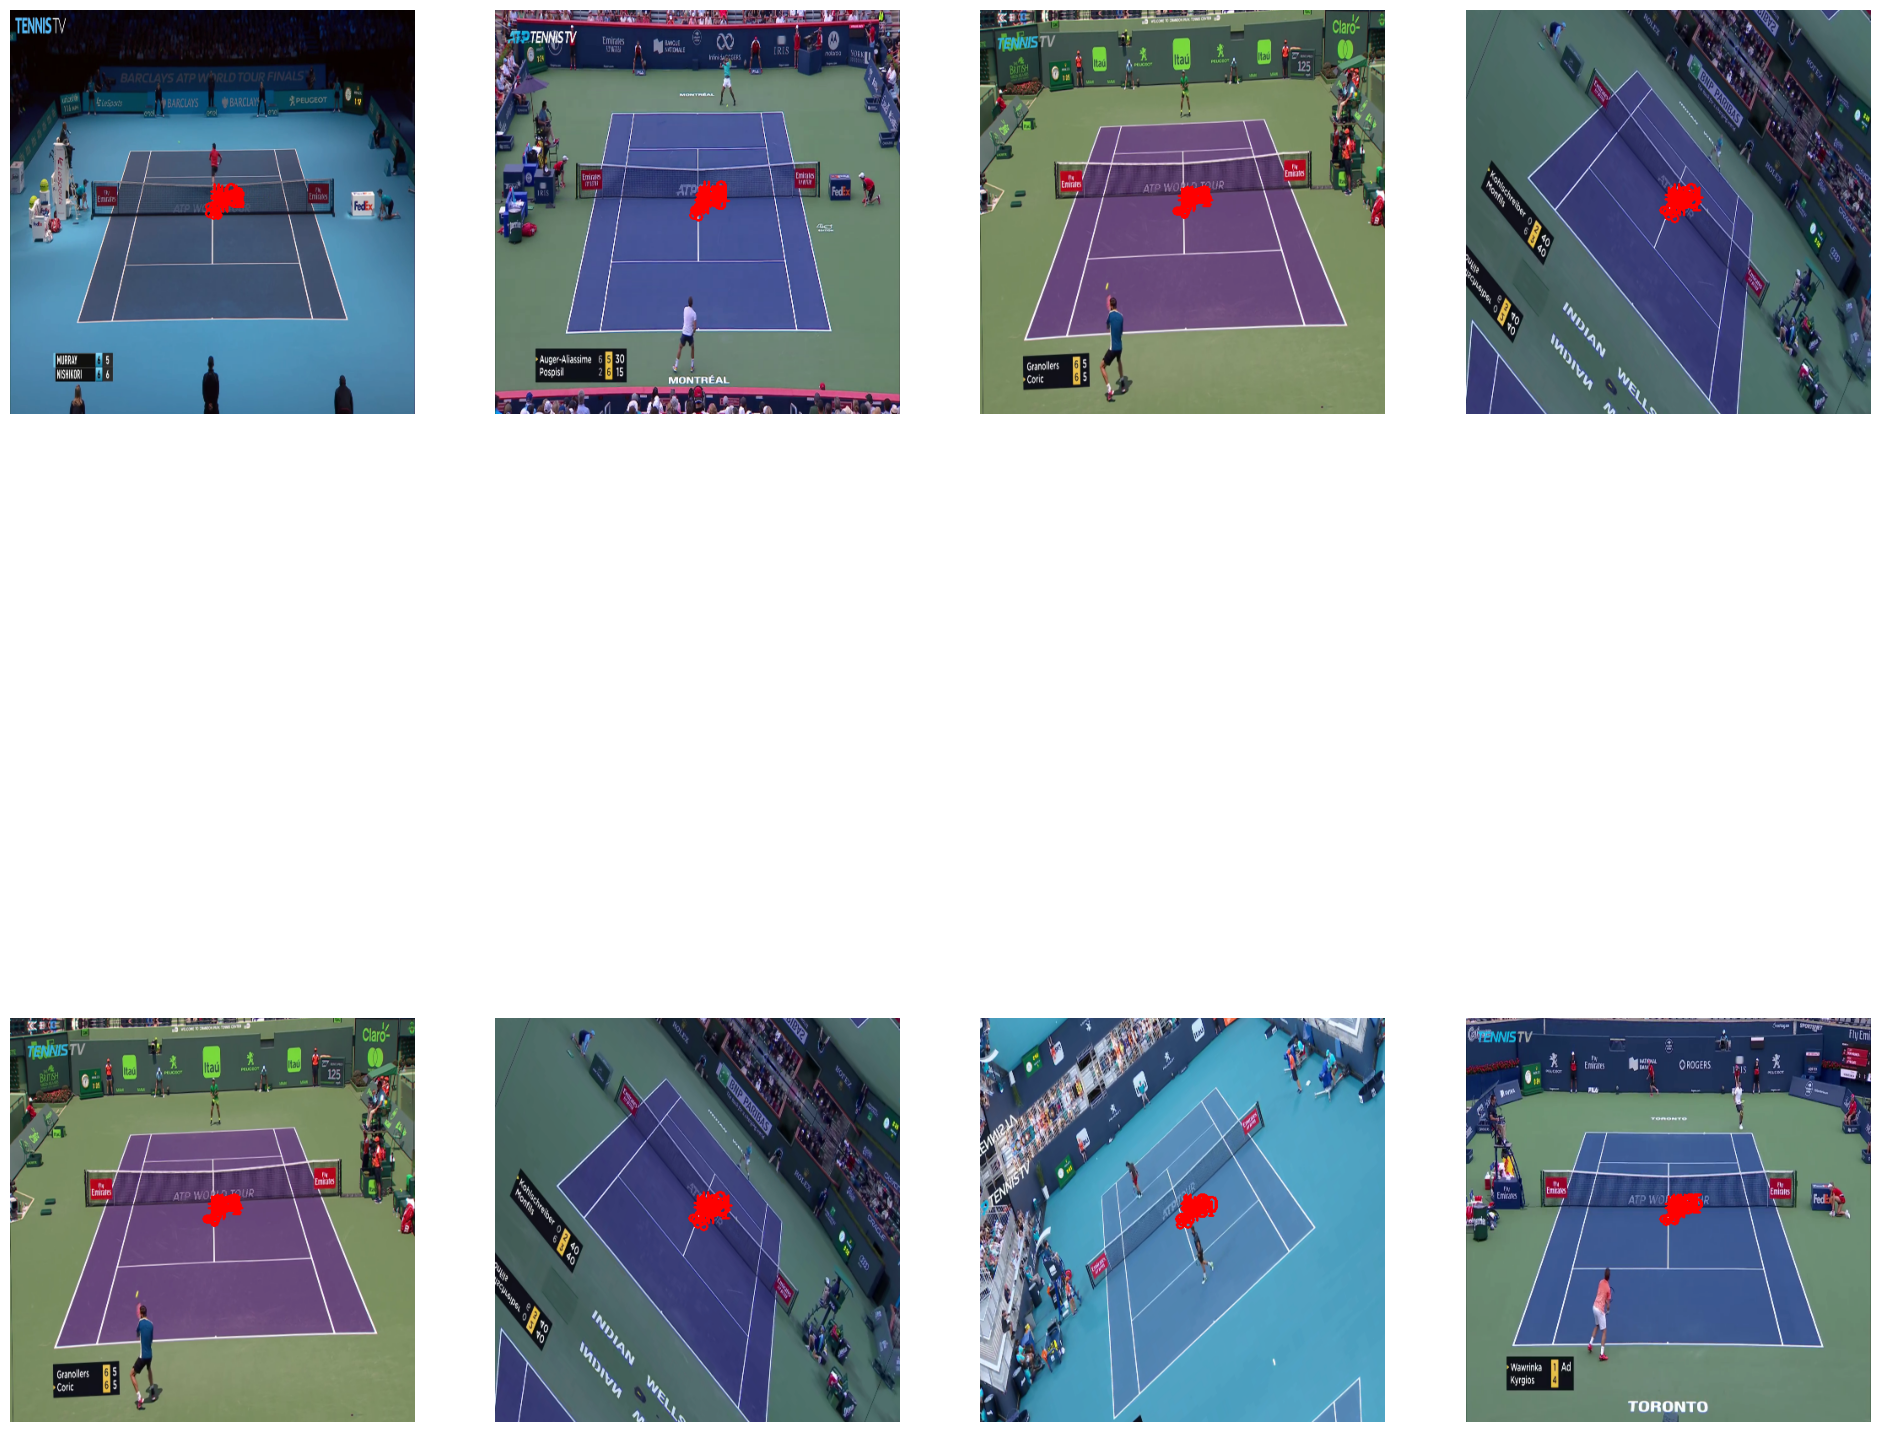

In [51]:
batch = next(iter(train_dl))
with torch.no_grad():
    x, y = batch
    predictions: torch.Tensor = pl_model(x)

    frames = []

    for img, pred in zip(x, predictions):
        print(f'img shape: {img.shape}')

        pred[:, 0] *= img.shape[1]
        pred[:, 1] *= img.shape[2]

        print(f'Predictions shape: {pred.shape}, value: {pred}')

        frame = draw_tensor(img, pred)
        frames.append(frame)

n_rows, n_cols = len(frames) // 4, 4
fig, axis = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(24,24))

for row in range(n_rows):
    for col in range(n_cols):
        idx = row * n_rows + col
        frame = frames[idx]
        axis[row, col].imshow(frame)
        axis[row, col].axis('off')

# plt.figure(figsize = (16, 16))
# plt.imshow(frame)
plt.axis('off')
plt.show()

## Data module

In [53]:
class TennisKeypointsDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_dataloader: DataLoader,
                 val_dataloader: DataLoader) -> None:
        super().__init__()
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader

    def setup(self, stage: str) -> None:
        print(f'Setup dataloader for stage: {stage}')
        return super().setup(stage)

    def train_dataloader(self) -> Any:
        return self.train_dl
    
    def val_dataloader(self):
        return self.train_dl

## Trainer


In [54]:
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'{pl_model.base_folder}',
    filename='kp-tennis-{epoch:02d}-{val_loss:.2f}',
    every_n_epochs=5
)

csv_logger = CSVLogger(save_dir=f'{pl_model.base_folder}')


data_m = TennisKeypointsDataModule(train_dl, val_dl)

trainer = Trainer(
    logger=csv_logger,
    log_every_n_steps=5,
    max_epochs=10,
    callbacks=[checkpoint_callback],
    limit_train_batches=10,
    limit_val_batches=5)

trainer.fit(pl_model, datamodule=data_m)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | model   | KeyPointsModel | 9.3 M  | train
1 | loss_fn | KpLoss         | 0      | train
---------------------------------------------------
1.5 M     Trainable params
7.8 M     Non-trainable params
9.3 M     Total params
37.120    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type           | Params | Mode 
---------------------------------------------------
0 | model   | KeyPointsModel | 9.3 M  | train
1 | loss_fn | KpLoss         | 0      | train
---------------------------------------------------
1.5 M     Trainable params
7.8 M     Non-trainable params
9.3 M     Total params
37.120    Total estimated model params size (MB)


Setup dataloader for stage: TrainerFn.FITTING
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/dimoynwa/anaconda3/envs/yolov5/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 5: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s, v_num=7]Validation batch index: 0
Create folder kps-28-07-2024-15-26-06/Epoch_5
Successfully saved image to kps-28-07-2024-15-26-06/Epoch_5/epoch_5_index_0_results.png
Successfully saved image to kps-28-07-2024-15-26-06/Epoch_5/epoch_5_index_1_results.png
Successfully saved image to kps-28-07-2024-15-26-06/Epoch_5/epoch_5_index_2_results.png
Successfully saved image to kps-28-07-2024-15-26-06/Epoch_5/epoch_5_index_3_results.png
Successfully saved image to kps-28-07-2024-15-26-06/Epoch_5/epoch_5_index_4_results.png
Successfully saved image to kps-28-07-2024-15-26-06/Epoch_5/epoch_5_index_5_results.png
Successfully saved image to kps-28-07-2024-15-26-06/Epoch_5/epoch_5_index_6_results.png
Successfully saved image to kps-28-07-2024-15-26-06/Epoch_5/epoch_5_index_7_results.png
Epoch 9: 100%|██████████| 10/10 [00:11<00:00,  0.90it/s, v_num=7]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:11<00:00,  0.90it/s, v_num=7]
